In [6]:
import pickle
import time
import datetime

import pandas as pd
import numpy as np
import optuna

import torch
from ray import tune

from nam.data import NAMDataset, FoldedDataset, load_sklearn_housing_data, load_breast_data
from nam.config import defaults
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM, Trainer
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

In [7]:
with open('../data/clean_data.pickle', 'rb') as file:
    data_dict = pickle.load(file)

y = data_dict['y']#.head(100)
X = data_dict['X']#.head(100)

In [8]:
X

,CutoffLTV,CutoffDSCR,CutoffCpn,log_bal,fixed,buildingage,CutoffOcc,Size,OVER_w,past_over,...,year_priced_2019.0,year_priced_2020.0,year_priced_2021.0,type_AGENCY-DUS,type_Agency,type_Conduit,type_Large Loan,type_Other,type_SASB,type_Small Bal
1,0.664,1.340,4.990,16.518549,0.0,2.944439,0.954,45000.000000,0.102015,0.308108,...,0,0,0,0,1,0,0,0,0,0
4,0.750,1.316,4.140,14.440914,0.0,2.890372,0.949,10260.000000,0.004555,0.308057,...,0,0,0,0,1,0,0,0,0,0
6,0.587,1.266,4.410,16.871868,0.0,3.806663,1.000,51217.000000,-0.113601,0.264368,...,1,0,0,0,1,0,0,0,0,0
7,0.659,1.375,4.010,16.133181,1.0,0.000000,0.962,5187.767090,-0.022408,0.120879,...,0,0,0,0,1,0,0,0,0,0
8,0.742,1.380,3.790,17.504391,1.0,4.753590,0.924,2491.824707,-0.130943,0.518519,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40038,0.700,1.580,3.830,13.840203,1.0,2.890372,0.943,4960.000000,-0.024262,0.000000,...,0,1,0,0,0,1,0,0,0,0
40040,0.743,1.570,5.910,15.800641,1.0,2.944439,0.983,55199.000000,-0.283679,0.316291,...,0,0,0,0,0,1,0,0,0,0
40041,0.642,1.318,3.948,17.448877,1.0,1.609438,0.984,11070.000000,-0.049587,0.118774,...,0,0,0,0,0,1,0,0,0,0
40042,0.732,1.900,4.838,16.491037,1.0,0.693147,0.985,6192.481445,-0.125048,0.181729,...,0,0,0,0,1,0,0,0,0,0


In [9]:
len(X)

25466

<Axes: >

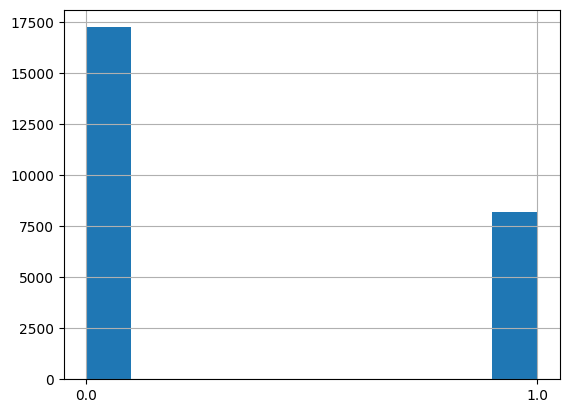

In [10]:
y.hist()

In [11]:
config = defaults()
config

namespace(device='cpu',
          seed=2021,
          data_path='data/GALLUP.csv',
          experiment_name='NAM',
          regression=False,
          num_epochs=1,
          lr=0.0003,
          batch_size=1024,
          logdir='output',
          wandb=True,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.5,
          decay_rate=0.995,
          l2_regularization=0.5,
          output_regularization=0.5,
          num_basis_functions=1000,
          units_multiplier=2,
          shuffle=True,
          cross_val=False,
          num_folds=5,
          num_splits=3,
          fold_num=1,
          num_models=1,
          num_workers=16,
          save_model_frequency=2,
          save_top_k=3,
          use_dnn=False,
          early_stopping_patience=50)

In [12]:
feature_cols = X.columns
X['Distress'] = y.astype(float)

config.logdir = 'NAM_testing'
config.wandb = False
# config.cross_val = True
config.cross_val = False # nur fuer den Testdatensatz
# Ich brauch FoldedDataset, das macht Cross Validation
config.num_epochs = 50
nam_dataset = load_breast_data(config)

In [13]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
logdir = f"NAM_run_{formatted_datetime}"
logdir

'NAM_run_2023-09-07_00-23-23'

In [14]:
# Neural Additive Model
config.logdir = logdir
nam_dataset = NAMDataset(
    config,
    data_path=X,
    features_columns=feature_cols,
    targets_column='Distress',
)
nam_model = NAM(
    config=config,
    name='Testing_NAM',
    num_inputs=len(nam_dataset[0][0]),
    num_units=get_num_units(config, nam_dataset.features)
)
data_loaders = nam_dataset.train_dataloaders()
for fold, (train_loader, val_loader) in enumerate(data_loaders):
     tb_logger = TensorBoardLogger(
          save_dir=config.logdir,
          name=f'{nam_model.name}',
          version=f'fold_{fold + 1}')

     checkpoint_callback = ModelCheckpoint(
          filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
          monitor='val_loss',
          save_top_k=config.save_top_k,
          mode='min'
     )
     litmodel = LitNAM(config, nam_model)
     pl.Trainer()
     trainer = pl.Trainer(
          logger=tb_logger,
          max_epochs=config.num_epochs,
          callbacks=checkpoint_callback,
     )
     # print('=============================')
     # print('=============================')
     # print('target_set')
     # target_set = [batch[1] for batch in train_loader]
     # # target_test = pd.DataFrame(target_set)
     # df = pd.DataFrame(torch.cat(target_set))
     # print('data lenght', len(df))
     # df.hist()
     # print('=============================')
     trainer.fit(
          litmodel,
          train_dataloaders=train_loader,
          val_dataloaders=val_loader)
     print('-------------------------------------------------------------------------')
     print('metrics', trainer.callback_metrics)
     print('-------------------------------------------------------------------------')

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 641 K 
-------------------------------
641 K     Trainable params
0         Non-trainable params
641 K     Total params
2.566     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Proje

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


-------------------------------------------------------------------------
metrics {'train_loss': tensor(139.1250, device='mps:0'), 'train_loss_step': tensor(139.1250, device='mps:0'), 'AUROC_metric': tensor(0.4798, device='mps:0'), 'AUROC_metric_step': tensor(0.4798, device='mps:0'), 'val_loss': tensor(140.1230, device='mps:0'), 'val_loss_epoch': tensor(140.1230, device='mps:0'), 'AUROC_metric_epoch': tensor(0.5030, device='mps:0'), 'train_loss_epoch': tensor(140.9560, device='mps:0')}
-------------------------------------------------------------------------


In [15]:
trainer.test(litmodel, dataloaders=nam_dataset.test_dataloaders())

/Users/janik/Documents/Master/KIT/Semester 4/Advanced Machine Learning Projekt/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   AUROC_metric_epoch       0.49125969409942627
     test_loss_epoch        138.95773315429688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 138.95773315429688,
  'AUROC_metric_epoch': 0.49125969409942627}]

In [ ]:
trainer.callback_metrics

In [ ]:
feature_cols = X.columns
X['Distress'] = y.astype(float)
config.logdir = 'NAM_testing'
# Ich brauch FoldedDataset, das macht Cross Validation
config.cross_val = True

def training(cfg):
    # Neural Additive Model
    config.update(**cfg)
    nam_dataset = FoldedDataset(
        config,
        data_path=X,
        features_columns=feature_cols,
        targets_column='Distress',
    )
    nam_model = NAM(
        config=config,
        name='Testing_NAM',
        num_inputs=len(nam_dataset[0][0]),
        num_units=get_num_units(config, nam_dataset.features)
    )
    # NAM Training
    data_loaders = nam_dataset.train_dataloaders()
    for fold, (train_loader, val_loader) in enumerate(data_loaders):
        tb_logger = TensorBoardLogger(
            save_dir=config.logdir,
            name=f'{nam_model.name}',
            version=f'fold_{fold + 1}')

        checkpoint_callback = ModelCheckpoint(
            filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
            monitor='val_loss',
            save_top_k=config.save_top_k,
            mode='min'
        )
        litmodel = LitNAM(config, nam_model)
        pl.Trainer()
        trainer = pl.Trainer(
            logger=tb_logger,
            max_epochs=config.num_epochs,
            callbacks=checkpoint_callback,
        )
        trainer.fit(
            litmodel,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)

In [ ]:
if sys.argv[1] == 'NAM':
    direction = 'maximimize'
    # direction = 'minimize'
    study_LR = optuna.create_study(
        direction=direction,
        # storage="mysql://root@localhost/logreg",
        study_name='LogisticRegression_study'
    )
    objective_LR = partial(objective, clf_type='LogisticRegression', X=X, y=y)
    study_LR.optimize(objective_LR, n_trials=n_trials, show_progress_bar=True)

    best_params_LR = study_LR.best_params
    best_LR_value = study_LR.best_value
    with open(f'models/best_params_LR_{direction}.joblib', 'wb') as file:
        joblib.dump({'params':best_params_LR, 'auroc_score':best_LR_value}, file)

In [ ]:
def nam_tuning(cfg):
    

In [ ]:
# result = tune.Tuner(
#     training,
#     num_samples=1,
#     metric="loss",
#     mode="min",
#     config={
#         "lr": tune.loguniform(1e-4, 1e-1),
#         "l2_regularization": tune.loguniform(0.01, 1.0),
#         "output_regularization": tune.loguniform(0.01, 1.0),
#         "dropout": tune.loguniform(0.01, 1.0),
#         "feature_dropout": tune.loguniform(0.01, 1.0),
#         "batch_size": tune.choice([128, 512, 1024]),
#         "hidden_sizes": tune.choice([[], [32], [64, 32]])
#     }
# )



In [ ]:
fig = plot_mean_feature_importance(litmodel.model, nam_dataset)

In [ ]:
# fig = plot_nams(litmodel.model, nam_dataset, num_cols=3)
fig = plot_nams(litmodel.model, nam_dataset, num_cols=3)